✅ Loaded 60 files.
✅ MAE: 0.3358
✅ MSE: 0.2396
✅ RMSE: 0.4895
✅ R² Score: 0.7316


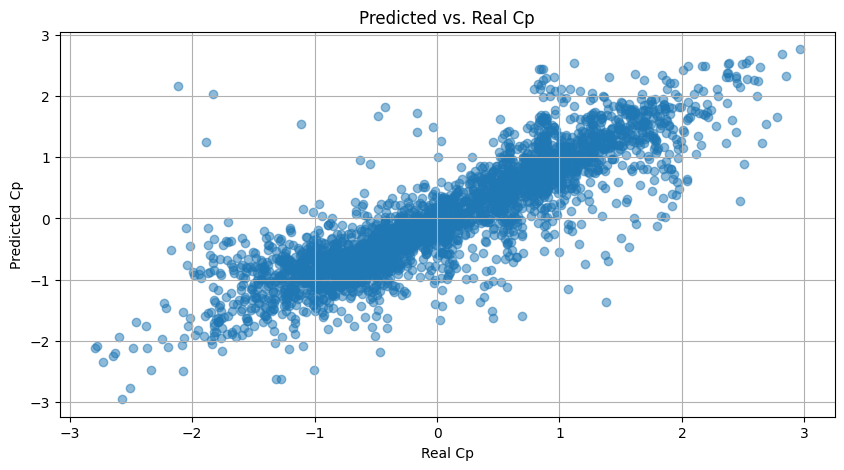

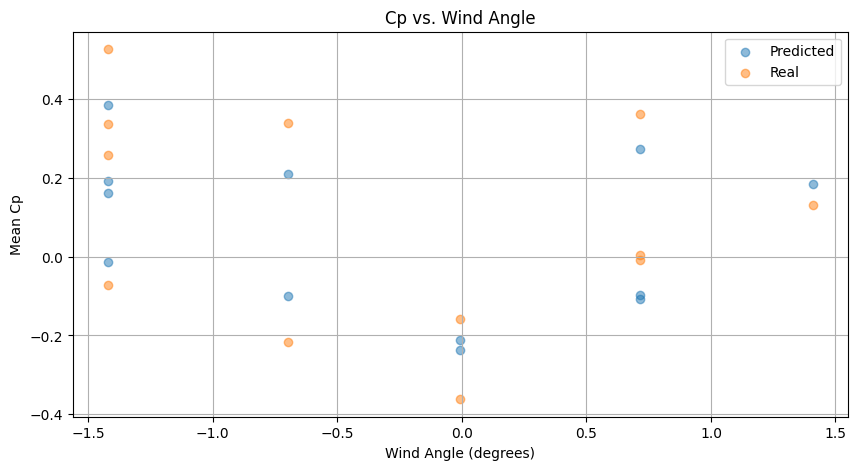

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# PINN Model Definition
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_classes):
        super(PINN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1)
        )
        self.regressor = nn.Sequential(
            nn.Linear(input_size + num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        class_probs = self.classifier(x)
        x_combined = torch.cat((x, class_probs), dim=1)
        return self.regressor(x_combined), class_probs

# Load and preprocess data from multiple .mat files
def load_all_data(folder_path):
    X_list, y_list, labels_list = [], [], []
    file_count = 0

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mat"):
            file_path = os.path.join(folder_path, file_name)
            data = sio.loadmat(file_path)

            # Extract metadata
            wind_angle = float(data.get('Wind_azimuth', [[0]])[0][0])
            height = float(data.get('Building_height', [[1]])[0][0])
            depth = float(data.get('Building_depth', [[1]])[0][0])
            height_ratio = height / max(depth, 1e-6)

            # Extract wind pressure coefficients
            Cp_matrix = data.get('Wind_pressure_coefficients', np.zeros((1, 256)))
            Cp_mean = np.mean(Cp_matrix, axis=0).flatten()
            Cp_mean = Cp_mean[:256] if len(Cp_mean) > 256 else np.pad(Cp_mean, (0, 256 - len(Cp_mean)), mode='constant')


            # Extract eave type
            eave_type = str(data.get('Eave_type', [['Unknown']])[0][0])

            # Append data
            X_list.append([wind_angle, height_ratio])
            y_list.append(Cp_mean)
            labels_list.append(eave_type)
            file_count += 1

    print(f"✅ Loaded {file_count} files.")
    return np.array(X_list), np.array(y_list), np.array(labels_list, dtype=object)

# Load all data
data_folder = "C:/Users/rrsuj/Downloads/capstone/data"
X, y, labels = load_all_data(data_folder)

# Encode categorical labels
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
labels_encoded = encoder.fit_transform(labels.reshape(-1, 1))
X_combined = np.hstack((X, labels_encoded))

# Standardize features and target
scaler_X = StandardScaler()
X_combined = scaler_X.fit_transform(X_combined)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Move data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Model setup
input_size = X_train.shape[1]
hidden_size = 128
output_size = y_train.shape[1]
num_classes = labels_encoded.shape[1]
model = PINN(input_size, hidden_size, output_size, num_classes).to(device)

# Load trained model
model.load_state_dict(torch.load("pinn_model_gpu.pth"))
model.eval()

# Predict
with torch.no_grad():
    y_pred, _ = model(X_test)
    y_pred = torch.nan_to_num(y_pred).cpu().numpy()
    y_test = y_test.cpu().numpy()

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'✅ MAE: {mae:.4f}')
print(f'✅ MSE: {mse:.4f}')
print(f'✅ RMSE: {rmse:.4f}')
print(f'✅ R² Score: {r2:.4f}')

# Plot Predicted vs. Real Cp
plt.figure(figsize=(10, 5))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
plt.xlabel("Real Cp")
plt.ylabel("Predicted Cp")
plt.title("Predicted vs. Real Cp")
plt.grid()
plt.show()

# Plot Cp vs. Wind Angle
plt.figure(figsize=(10, 5))
plt.scatter(X_test[:, 0].cpu().numpy(), y_pred.mean(axis=1), label="Predicted", alpha=0.5)
plt.scatter(X_test[:, 0].cpu().numpy(), y_test.mean(axis=1), label="Real", alpha=0.5)
plt.xlabel("Wind Angle (degrees)")
plt.ylabel("Mean Cp")
plt.title("Cp vs. Wind Angle")
plt.legend()
plt.grid()
plt.show()

# User input for prediction
user_wind_angle = float(input("Enter wind angle (degrees): "))
user_height_ratio = float(input("Enter height ratio: "))
user_eave_type = input("Enter eave type (A, B, C, O): ")

# Encode user input
eave_encoded = encoder.transform([[user_eave_type]]).toarray()
user_input = np.hstack(([user_wind_angle, user_height_ratio], eave_encoded))
user_input = scaler_X.transform([user_input])
user_input = torch.tensor(user_input, dtype=torch.float32).to(device)

# Predict Cp
with torch.no_grad():
    user_pred, _ = model(user_input)
    user_pred = scaler_y.inverse_transform(user_pred.cpu().numpy())

print(f"Predicted Cp values: {user_pred.flatten()}")
